# Compute Connectome Harmonics

In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os
from pathlib import Path

# Dynamically set the working directory to the project root
project_root = Path.cwd().parent.parent
os.chdir(project_root)
sys.path.append(os.path.join(os.getcwd(), 'src'))

import ch
from ch.settings import load_settings
from ch.data_handling.io import load_matlab_file
from ch.data_handling.metadata import load_metadata

# Load settings
settings = load_settings()

# Load metadata - pass settings object
subject_metadata = load_metadata(settings, table='subjects')

subject_metadata.head(10)


19:28:13 - ch.data_handling.metadata - INFO - Loading subjects metadata from metadata/subject_metadata.parquet
19:28:13 - ch.data_handling.metadata - INFO - Loaded metadata for 594 subjects


,age,dataset,scan_type,n_regions,has_yeo_labels,created_at,updated_at
subject_id,,,,,,,
1,24,camcan,DTI,376,True,2025-09-05 14:10:52.072141,2025-09-05 15:01:31.558620
2,28,camcan,DTI,376,True,2025-09-05 14:10:52.072141,2025-09-05 15:01:31.558620
3,28,camcan,DTI,376,True,2025-09-05 14:10:52.072141,2025-09-05 15:01:31.558620
4,23,camcan,DTI,376,True,2025-09-05 14:10:52.072141,2025-09-05 15:01:31.558620
5,22,camcan,DTI,376,True,2025-09-05 14:10:52.072141,2025-09-05 15:01:31.558620
6,25,camcan,DTI,376,True,2025-09-05 14:10:52.072141,2025-09-05 15:01:31.558620
7,18,camcan,DTI,376,True,2025-09-05 14:10:52.072141,2025-09-05 15:01:31.558620
8,25,camcan,DTI,376,True,2025-09-05 14:10:52.072141,2025-09-05 15:01:31.558620
9,28,camcan,DTI,376,True,2025-09-05 14:10:52.072141,2025-09-05 15:01:31.558620


In [ ]:
# Example: Using instantiate_metadata (will show warning since metadata exists)
print("🏗️ Example: Using instantiate_metadata function")

try:
    # This will fail because metadata already exists
    ch.data_handling.metadata.instantiate_metadata(settings, metadata)
except FileExistsError as e:
    print(f"❌ Expected error: {e}")
    print("✅ Safety check working correctly!")

print("\n📝 To use instantiate_metadata, you would need to delete the existing file first:")
print("   settings.metadata_parquet.unlink()  # Delete existing file")
print("   ch.data_handling.metadata.instantiate_metadata(settings, new_df)")


In [ ]:
import ch

camcan_metadata = ch.data_handling.metadata.extract_camcan_metadata(settings)
print(camcan_metadata.info())
print(metadata.head())


# Example: Using the simplified update_metadata function
print("📝 Example: Using the simplified update_metadata function")

# Extract metadata
camcan_metadata = ch.data_handling.metadata.extract_camcan_metadata(settings)

# Update metadata with the DataFrame - simple and clean!
# Note: This would now use instantiate_metadata() for creating new metadata
# or update_metadata() for adding/updating columns
ch.data_handling.metadata.update_metadata(settings, camcan_metadata, 'age')

print("✅ Metadata updated successfully!")
print(f"   Shape: {camcan_metadata.shape}")
print(f"   Columns: {list(camcan_metadata.columns)}")

camcan_metadata = ch.data_handling.metadata.extract_camcan_metadata(settings)
print(camcan_metadata.info())
print(metadata.head())



In [6]:
import ch

ch.data_handling.metadata.create_metadata_summary(settings, table='subjects')


18:54:10 - ch.data_handling.metadata - INFO - Loading subjects metadata from metadata/subject_metadata.parquet
18:54:10 - ch.data_handling.metadata - INFO - Loaded metadata for 594 subjects


{'total_subjects': 594,
 'datasets': {'camcan': 594},
 'age_stats': {'min': 18.0,
  'max': 88.0,
  'mean': 53.55723905723906,
  'std': 18.158685659402444},
 'scan_types': {'DTI': 594},
 'atlas_versions': {}}

In [ ]:
# Example: Adding and then deleting a column
import pandas as pd
import numpy as np

print("🗑️ Example: Adding and deleting a column")

# First, add a test column
test_data = pd.DataFrame({
    'subject_id': [1, 2, 3, 4, 5],
    'test_score': np.random.normal(50, 10, 5)
})

print("Adding test column...")
ch.data_handling.metadata.update_metadata(settings, test_data, 'test_score')

# Check it was added
metadata_with_test = ch.data_handling.metadata.load_metadata(settings)
print(f"✅ Columns after adding: {list(metadata_with_test.columns)}")

# Now delete it
print("\nDeleting test column...")
ch.data_handling.metadata.delete_metadata_column(settings, 'test_score')

# Check it was deleted
metadata_after_delete = ch.data_handling.metadata.load_metadata(settings)
print(f"✅ Columns after deleting: {list(metadata_after_delete.columns)}")

# Try to delete a critical column (should fail)
print("\nTrying to delete critical column 'age'...")
try:
    ch.data_handling.metadata.delete_metadata_column(settings, 'age')
except ValueError as e:
    print(f"❌ Expected error: {e}")
    print("✅ Safety check working correctly!")


In [ ]:
# Example: Using utility functions for metadata management
print("🔧 Example: Using utility functions")

# Create a backup before making changes
print("Creating metadata backup...")
backup_path = ch.data_handling.metadata.backup_metadata(settings)
print(f"✅ Backup created: {backup_path}")

# Get info for a specific subject
print("\nGetting info for subject 1:")
subject_info = ch.data_handling.metadata.get_subject_info(settings, 1)
print(subject_info)

# Get statistics for the age column
print("\nAge column statistics:")
age_stats = ch.data_handling.metadata.get_column_stats(settings, 'age')
for key, value in age_stats.items():
    print(f"  {key}: {value}")

# Get statistics for a categorical column
print("\nDataset column statistics:")
dataset_stats = ch.data_handling.metadata.get_column_stats(settings, 'dataset')
for key, value in dataset_stats.items():
    print(f"  {key}: {value}")


# Populate Xarray with connectivity matrices

In [2]:
import scipy.io as sio
data = sio.loadmat(settings.camcan_raw)
print({k: getattr(v, "shape", None) for k,v in data.items() if not k.startswith("__")})

{'age': (594, 1), 'nets': (376, 376, 594), 'None': (1,), 'yeoLabs': (1, 1)}


In [4]:
# Build and save the connectivity xarray store (adjacency matrices)
from ch.data_handling.data_utils import populate_connectivity_store, open_connectivity_dataset

store_path = populate_connectivity_store(settings, overwrite=True)
print("Connectivity store created at:", store_path)

# Open it back to inspect dims/vars
conn_ds = open_connectivity_dataset(settings, atlas='AAL-376')
display(conn_ds)
print('adjacency shape:', conn_ds.connectivity.shape)


19:29:26 - ch.data_handling.data_utils - INFO - Loading raw MATLAB data (keys: 'nets', 'age')
19:29:28 - ch.data_handling.data_utils - INFO - Connectivity Zarr written at processed/connectivity_AAL-376.nc


Connectivity store created at: /Users/daylight/dev/code/connectome-harmonics-code/data/processed/connectivity_AAL-376.nc


<xarray.Dataset> Size: 672MB
Dimensions:       (subject: 594, node: 376, node_2: 376)
Coordinates:
  * subject       (subject) int32 2kB 1 2 3 4 5 6 7 ... 589 590 591 592 593 594
  * node          (node) int32 2kB 0 1 2 3 4 5 6 ... 369 370 371 372 373 374 375
  * node_2        (node_2) int32 2kB 0 1 2 3 4 5 6 ... 370 371 372 373 374 375
Data variables:
    connectivity  (subject, node, node_2) float64 672MB ...
Attributes:
    atlas:        AAL-376
    description:  DTI structural connectivity (fiber density)
    layout:       subject,node,mode-compatible

adjacency shape: (594, 376, 376)


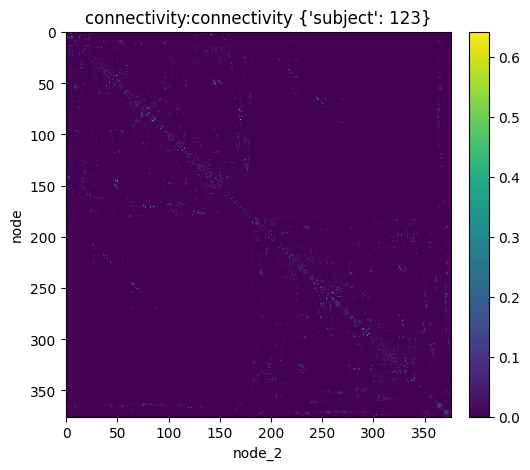

In [5]:
from ch.viz.heatmaps import plot_heatmap

ax = plot_heatmap(settings, dataset="connectivity", var="connectivity", sel={"subject": 123})